##### **Montando nuestro directorio de Drive**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/My Drive/DATASETS/GAN"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
/content/gdrive/My Drive/DATASETS/GAN


##### **Importando librerías**

In [ ]:
# generales:
import os
import numpy as np
import tensorflow as tf

print('tensorflow version', tf.__version__)

tensorflow version 2.4.1


In [ ]:
# para las redes neuronales:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D # new!
from keras.optimizers import RMSprop, SGD

In [ ]:
# para plotting:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

##### **Importando el dataset**

In [ ]:
# cargamos el dataset
inputImgs = "apple.npy"
data = np.load(inputImgs)

In [ ]:
# dimensiones originales del dataset
print('dataset dims:', data.shape[0], '✕', data.shape[1], '(= 28 ✕ 28 ✕ 1)')

dataset dims: 144722 ✕ 784 (= 28 ✕ 28 ✕ 1)


In [ ]:
# normalizando
data = data/255
# redimensionando el dataset: 144722 instancias de dim 28 ✕ 28
data = np.reshape(data, (data.shape[0], 28, 28, 1))
# dimesiones de la imagen
img_w, img_h = data.shape[1:3]

print('img dims:', img_w, '✕', img_h)

img dims: 28 ✕ 28


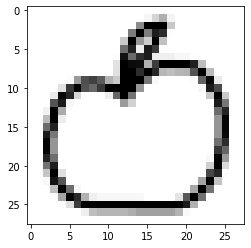

In [ ]:
# observar la instancia 100
plt.imshow(data[100, :, :, 0], cmap='Greys')
plt.show()

## **(A) Red Discriminadora**

**1. Definimos el modelo de la red** 

In [ ]:
def discriminatorBuilder(depth=64, p=0.4):
    # definir los inputs
    inputs = Input((img_w, img_h, 1))

    # definir las capas onvolutionales
    conv1 = Conv2D(depth * 1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth * 2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth * 4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth * 8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))

    # capa de salida
    output = Dense(1, activation='sigmoid')(conv4)

    # definir el modelo y observar el summary
    model = Model(name='Discriminator', inputs=inputs, outputs=output)
    model.summary()

    return model

**2. Definimos funciones que nos generen la información que entrenará a la discriminadora** 

In [ ]:
def generateRealImgs(data, batch=128):
    # muestrear imagenes reales
    realImgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch, 28, 28, 1))
    # generar los targets para las imagenes reales (1)
    realTrgs = np.ones((batch, 1))

    return realImgs, realTrgs

In [ ]:
""" OPCIONAL
"""
def generateFakeImgs(batch=128):
    # generar imagenes falsas
    fakeImgs = np.random.uniform(-1.0, 1.0, size=[batch, 28*28*1])
    fakeImgs = fakeImgs.reshape((batch, 28, 28, 1))
    # generar los targets para las imagenes falsas (0)
    fakeTrgs = np.zeros((batch, 1))

    return fakeImgs, fakeTrgs 

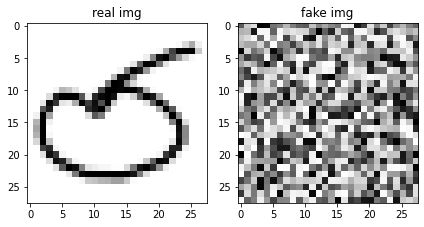

In [ ]:
""" OPCIONAL
"""
realX, realY = generateRealImgs(data)
fakeX, fakeY = generateFakeImgs()

# observar la instancia 5 tanto del batch de imagenes reales como de la falsas
axes = []
fig=plt.figure()
# real
axes.append(fig.add_subplot(1, 2, 1))
subplot_title=('real img')
axes[-1].set_title(subplot_title)
plt.imshow(realX[5, :, :, 0], cmap='Greys')
# falsa
axes.append(fig.add_subplot(1, 2, 2))
subplot_title=('fake img')
axes[-1].set_title(subplot_title)
plt.imshow(fakeX[5, :, :, 0], cmap='Greys')

fig.tight_layout()
plt.show()

**3. Proceso de entrenamiento de la red discriminadora** 

In [ ]:
""" OPCIONAL
"""
def trainDiscriminator(data, epochs=30, batch=128):
  # guardaremos las métricas de desempeño de la red discriminadora
  discMetrics = []
  # particionamos el batch para reales y falsas
  halfBatch = int(batch/2)

  for _ in range(epochs):
    realX, realY = generateRealImgs(data, batch=halfBatch)
    fakeX, fakeY = generateFakeImgs(batch=halfBatch)
    # creando una solo dataset
    X = np.concatenate((realX, fakeX))
    y = np.concatenate((realY, fakeY))
    # entrenar la red
    discMetrics.append(discriminator.train_on_batch(X, y))
    
  return discMetrics

**4. Instanciamos y compilamos nuestra red discriminadora** 

In [ ]:
# instanciamos y compilamos nuestra red discriminadora
discriminator = discriminatorBuilder()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                      metrics=['accuracy'])

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 256)       

**5. Entrenamos la red discriminadora** 

[]

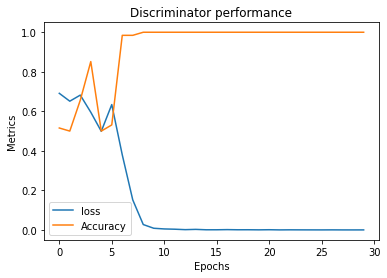

In [ ]:
""" OPCIONAL
"""
# observamos como la discriminadora aprende a discernir entre las imagenes
# falsas y las reales
discMetrics = trainDiscriminator(data=data)

# mostrando el loss de la red discriminadora
ax = pd.DataFrame({
    'loss':     [metric[0] for metric in discMetrics],
    'Accuracy': [metric[1] for metric in discMetrics],
  }
).plot(title='Discriminator performance')

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.plot()

## **(B) Red Generadora**

**1. Definimos el modelo de la red** 

In [ ]:
def generatorBuilder(z_dim=32, depth=64, p=0.4):
    # definir los inputs
    inputs = Input((z_dim,))

    # primer capa densa
    dense1 = Dense(7 * 7 * 64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)  # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7, 7, 64))(dense1)
    dense1 = Dropout(p)(dense1)

    # capas deconvolutionales
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth / 2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth / 4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth / 8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # capa de salida
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    # definir el modelo y observar el summary
    model = Model(name='Generator', inputs=inputs, outputs=output)
    model.summary()

    return model

**2. Definimos una función para guardar el modelo de la red generadora** 

In [ ]:
def saveGeneratorModel():
	# guardar el modelo de la red generadora
	filename = 'generator_model.h5'
	generator.save(filename)

**3. Definimos una función para generar espacios latentes** 

In [ ]:
def generateLatentSpace(z_dim=32, batch=128):
    # generamos el espacio latente
    return np.random.uniform(-1.0, 1.0, size=[batch, z_dim])

In [ ]:
""" OPCIONAL
"""
# observamos el espacio latente generado
X = generateLatentSpace()
X.shape

(128, 32)

**4. Definimos una función para generar imágenes falsas a partir de la red generadora** 

In [ ]:
def generateFakeImgs(z_dim=32, batch=128):
    # generamos el espacio latente
    X = generateLatentSpace(batch=batch)
    # generar imagenes falsas
    fakeImgs = generator.predict(X)
    # generar los targets para las imagenes falsas (0)
    fakeTrgs = np.zeros((batch, 1))

    return fakeImgs, fakeTrgs 

**5. Instanciamos nuestra red generadora** 

In [ ]:
# instanciamos nuestra red generadora
generator = generatorBuilder()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization_4 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 64)        0 

**5. Observamos una imagen falsa generada la red** 

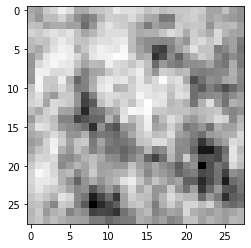

In [ ]:
""" OPCIONAL
"""
# generamos 128 imagenes falsas mediante la red generadora
fakeX, fakeY = generateFakeImgs()

# observar la instancia 5 de nuestro batch generado por la red
plt.imshow(fakeX[5, :, :, 0], cmap='Greys')
plt.show()

## **Red Adversarial**

**1. Definimos el modelo de la red adversarial en base a las redes discriminaroda y generadora** 

*ejecutar de nueva cuenta A4 y B5

In [ ]:
def adversarialBuilder(z_dim=32):
    model = Sequential(name='Adversarial')
    # Hacer pesos en la red discriminadora no entrenables
    discriminator.trainable = False
    # las redes generadora y discriminadora en cascada
    model.add(generator)
    model.add(discriminator)
    # compilamos la red adversarial y observamos el summary
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
# instanciamos nuestra red adversarial
adversarial = adversarialBuilder()

Model: "Adversarial"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Functional)       (None, 28, 28, 1)         183713    
_________________________________________________________________
Discriminator (Functional)   (None, 1)                 4311553   
Total params: 4,495,266
Trainable params: 177,329
Non-trainable params: 4,317,937
_________________________________________________________________


**2. Proceso de entrenamiento de la red adversarial** 

In [ ]:
def train(data, epochs=2000, z_dim=32, batch=128, instances=8, save=False):
  # guardaremos las métricas de desempeño tanto de la red adversarial
  # como de la red discriminadora
  advrMetrics = []
  discMetrics = []
  
  # particionamos el batch para reales y falsas
  halfBatch = int(batch/2)

  for epoch in range(epochs):
    # (1) ENTRENAMIENTO DE LA RED DISCRIMINADORA
    realX, realY = generateRealImgs(data, batch=halfBatch)
    fakeX, fakeY = generateFakeImgs(batch=halfBatch)
    # creando una solo dataset
    X = np.concatenate((realX, fakeX))
    y = np.concatenate((realY, fakeY))
    # entrenar la red
    discMetrics.append(discriminator.train_on_batch(X, y))

    # (2) ENTRENAMIENTO DE LA RED GAN
    # generamos el espacio latente
    X = generateLatentSpace()
    # creamos etiquetas invertidas para las muestras falsas
    y = np.ones([batch, 1])
    # entrenar la red
    advrMetrics.append(adversarial.train_on_batch(X, y))
    
    # mostramos el progreso del entrenamiento y las imagenes que se van generando
    if (epoch + 1) % 500 == 0:
      print('epoch #{}'.format(epoch + 1))
      # generamos imagenes a partir de un espacio latente con
      # un numero determinado de instancias
      imgs = generator.predict(generateLatentSpace(batch=instances))
      # dibujamos las imagenes
      plt.figure(figsize=(5, 5))
      for k in range(imgs.shape[0]):
        plt.subplot(1, instances,  k + 1)
        plt.imshow(imgs[k, :, :, 0], cmap='gray')
        plt.axis('off')
      plt.tight_layout()
      plt.show()
      
  # guaramos los pesos de la red generadora
  if save:
    saveGeneratorModel()
  return advrMetrics, discMetrics

In [ ]:
# almacenar las métricas de desempeño en caso de correr el algoritmo más de una vez
advrMetrics = []
discMetrics = []

epoch #500


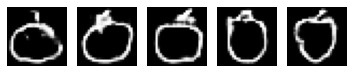

epoch #1000


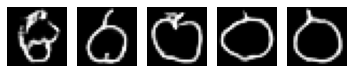

epoch #1500


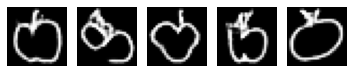

epoch #2000


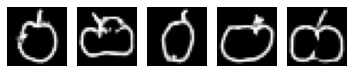

epoch #2500


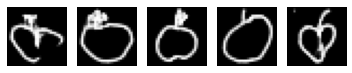

epoch #3000


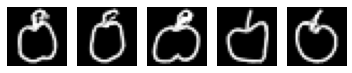

epoch #3500


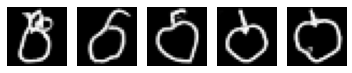

epoch #4000


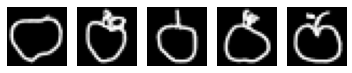

epoch #4500


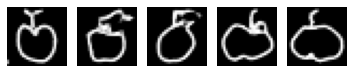

epoch #5000


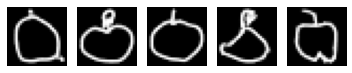

epoch #5500


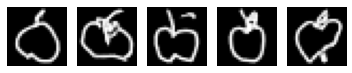

epoch #6000


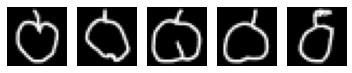

epoch #6500


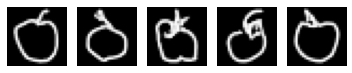

epoch #7000


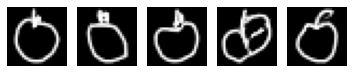

epoch #7500


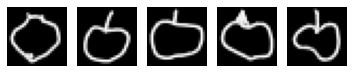

epoch #8000


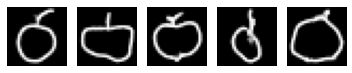

epoch #8500


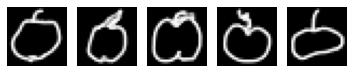

epoch #9000


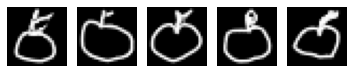

epoch #9500


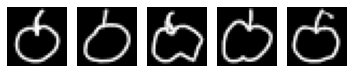

epoch #10000


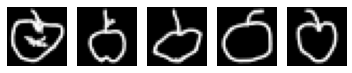

epoch #10500


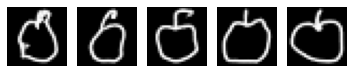

epoch #11000


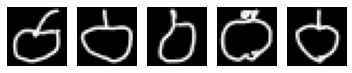

epoch #11500


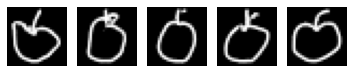

epoch #12000


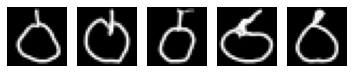

epoch #12500


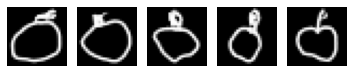

epoch #13000


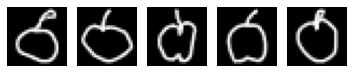

epoch #13500


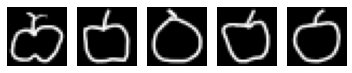

epoch #14000


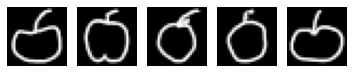

epoch #14500


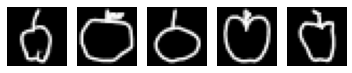

epoch #15000


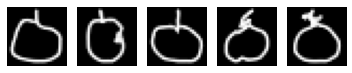

epoch #15500


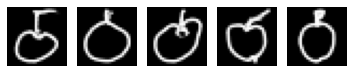

epoch #16000


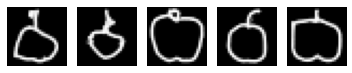

epoch #16500


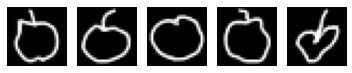

epoch #17000


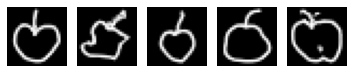

epoch #17500


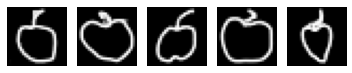

epoch #18000


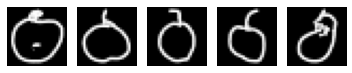

epoch #18500


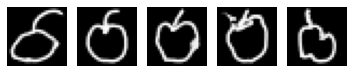

epoch #19000


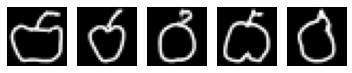

epoch #19500


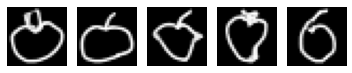

epoch #20000


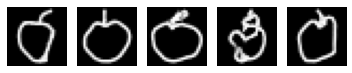

In [ ]:
# ejecutamos el algoritmo
aMetrics, dMetrics = train(data=data, epochs=20000, instances=5, save=True)
# acumulamos las métricas de desempeño
advrMetrics += aMetrics
discMetrics += dMetrics

##### **Métricas del desempeño de las redes**

[]

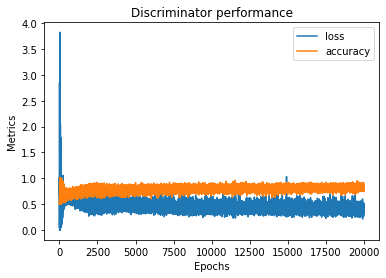

In [ ]:
# mostrando el loss de la red discriminadora
ax = pd.DataFrame({
    'loss':     [metric[0] for metric in discMetrics],
    'accuracy': [metric[1] for metric in discMetrics],
  }
).plot(title='Discriminator performance')

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.plot()

[]

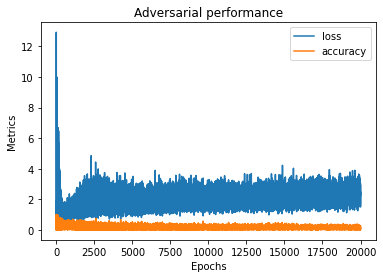

In [ ]:
# mostrando el loss de la red adversarial
ax = pd.DataFrame({
    'loss':     [metric[0] for metric in advrMetrics],
    'accuracy': [metric[1] for metric in advrMetrics],
  }
).plot(title='Adversarial performance')

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.plot()

## **Análisis cualitativo del desempeño de la red adversarial**

fake img dims: (10000, 28, 28, 1)


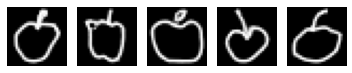

In [ ]:
# generamos un set de imagenes mediante la red adversarial
fakeImgs, _ = generateFakeImgs(batch=10000)

# observamos las dimensiones de la imagenes
print('fake img dims:', fakeImgs.shape)

# observar 5 instancias de nuestro batch generado por la red
# y las dibujamos
instances = 5
plt.figure(figsize=(5, 5))
for k in range(instances):
  sample = np.random.randint(fakeImgs.shape[0], size=1)[0]
  plt.subplot(1, instances,  k+1)
  plt.imshow(fakeImgs[sample, :, :, 0], cmap='gray')
  plt.axis('off')
plt.tight_layout()
plt.show()

real img dims: (10000, 28, 28, 1)


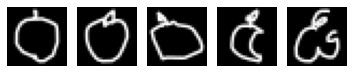

In [ ]:
# generamos un batch de imagenes reales extraidas del dataset
realImgs, _ = generateRealImgs(data, batch=10000)

# observamos las dimensiones de la imagenes
print('real img dims:', realImgs.shape)

# observar 5 instancias de nuestro batch generado por la red
# y las dibujamos
instances = 5
plt.figure(figsize=(5, 5))
for k in range(instances):
  sample = np.random.randint(realImgs.shape[0], size=1)[0]
  plt.subplot(1, instances,  k+1)
  plt.imshow(realImgs[sample, :, :, 0], cmap='gray')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# preparamos las imagenes para someterlas a un algoritmo de clustering (K-Means)
realImgs = realImgs.reshape(realImgs.shape[0], -1)
fakeImgs = realImgs.reshape(fakeImgs.shape[0], -1)

# observamos las dimensiones de los datasets para los clusters
print('real dataset dims:', realImgs.shape[0], '✕', realImgs.shape[1], '(= 28 ✕ 28 ✕ 1)')
print('real dataset dims:', realImgs.shape[0], '✕', realImgs.shape[1], '(= 28 ✕ 28 ✕ 1)')

real dataset dims: 10000 ✕ 784 (= 28 ✕ 28 ✕ 1)
real dataset dims: 10000 ✕ 784 (= 28 ✕ 28 ✕ 1)


In [ ]:
# generamos un solo dataset
imgs = np.concatenate((fakeImgs, realImgs))
print('complete dataset dims:', imgs.shape[0], '✕', imgs.shape[1], '(= 28 ✕ 28 ✕ 1)')

complete dataset dims: 20000 ✕ 784 (= 28 ✕ 28 ✕ 1)


##### **Aplicando _clustering_ para agrupar las imgenes que se asemejan más entre sí**

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from collections import Counter

In [ ]:
# numero de clusters: imagenes falsas e imagenes reales
numClusters = 2
# algoritmo de k-means
kmeans = MiniBatchKMeans(n_clusters=numClusters)
kmeans.fit(imgs)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [ ]:
clusters = Counter(kmeans.labels_)
clusters

Counter({0: 10198, 1: 9802})